# Week 17, Lecture 02: CodeAlong


## **Part 2: Explaining Models with Model Explainers**

### Lesson Objectives

- By the end of this lesson, students will be able to:
    - Load variables and models from a joblib file into a new notebook.
    - Apply permutation importance
    - Apply shap analysis 
    - Visualize global and local explanations.


### Continuing with Life Expectancy Prediction

**Goal**:  To understand how features of a country affect life expectancy

> Task Inspired by: https://medium.com/@shanzehhaji/using-a-linear-regression-model-to-predict-life-expectancy-de3aef66ac21

- Kaggle Dataset on Life Expectancy:
    - https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [2]:
## Importing Custom Functions
import sys,os
# sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from CODE import data_enrichment as de

### Functionized Code From Part 1

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

##  üïπÔ∏è Loading Objects from a Joblib

In [4]:
## Load the joblib file stored in the models folder
fname = "../Models/wk1-lect01-codealong.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])

In [5]:
## Saving the loaded objects as separate varaibles

## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

Year      Status  Adult Mortality  infant deaths  Alcohol  \
2414  2010  Developing         359.0000             27      NaN   
1576  2009  Developing         491.0000             36   1.1600   
2559  2009  Developing         174.0000             10   0.3000   
1524  2013   Developed         178.0000              0  15.0400   
33    2014  Developing          11.0000             21   0.0100   

      percentage expenditure  Hepatitis B  Measles     BMI  under-five deaths  \
2414                  0.0000          NaN        0     NaN                 41   
1576                  7.9151      93.0000       21 17.3000                 56   
2559                 35.7161      93.0000        0 35.9000                 12   
1524              1,968.8168      93.0000       35 61.4000                  0   
33                   54.2373      95.0000        0 58.4000                 24   

       Polio  Total expenditure  Diphtheria  HIV/AIDS         GDP  \
2414     NaN                NaN         NaN    4.0000  1,562.2393   
1576 93.0000             1.1800     93.0000   14.9000     42.7380   
2559 93.0000             5.9300     93.0000    0.2000    666.3459   
1524 93.0000             6.5900     93.0000    0.1000 15,712.8238   
33   95.0000             7.2100     95.0000    0.1000    547.8517   

          Population  thinness  1-19 years  thinness 5-9 years  \
2414    167,192.0000                   NaN                 NaN   
1576  1,471,462.0000                6.9000              6.8000   
2559  7,472,819.0000                3.7000              3.8000   
1524  2,957,689.0000                2.7000              2.7000   
33   39,113,313.0000                6.0000              5.8000   

      Income composition of resources  Schooling  
2414                           0.0000     0.0000  
1576                           0.4150     9.9000  
2559                           0.6010    11.1000  
1524                           0.8340    16.4000  
33                             0.7410    14.4000

> Let's evaluate our models to prove they saved correctly.

In [6]:
## Use our evaluate_regression function to evalaute the linear regression

evaluate_regression(lin_reg_final, X_train,y_train, X_test, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Status
Feature names seen at fit time, yet now missing:
- Status_Developing


> ***Q: what happened??***

> **Q: What is missing/wrong?**
....

...


### Re-Creating X_train_df & X_test_df

In [7]:
## Use the preprocessor to transform X_train into X_train_proc
X_train_proc = preprocessor.transform(X_train)


## Use the preprocessor to transform X_test into X_test_df 

X_test_proc = preprocessor.transform(X_test)

X_train_proc.head()


Year  Adult Mortality  infant deaths  Alcohol  \
2414 2,010.0000         359.0000        27.0000   4.5801   
1576 2,009.0000         491.0000        36.0000   1.1600   
2559 2,009.0000         174.0000        10.0000   0.3000   
1524 2,013.0000         178.0000         0.0000  15.0400   
33   2,014.0000          11.0000        21.0000   0.0100   

      percentage expenditure  Hepatitis B  Measles     BMI  under-five deaths  \
2414                  0.0000      81.4389   0.0000 38.1130            41.0000   
1576                  7.9151      93.0000  21.0000 17.3000            56.0000   
2559                 35.7161      93.0000   0.0000 35.9000            12.0000   
1524              1,968.8168      93.0000  35.0000 61.4000             0.0000   
33                   54.2373      95.0000   0.0000 58.4000            24.0000   

       Polio  Total expenditure  Diphtheria  HIV/AIDS         GDP  \
2414 82.4908             5.9320     82.4519    4.0000  1,562.2393   
1576 93.0000             1.1800     93.0000   14.9000     42.7380   
2559 93.0000             5.9300     93.0000    0.2000    666.3459   
1524 93.0000             6.5900     93.0000    0.1000 15,712.8238   
33   95.0000             7.2100     95.0000    0.1000    547.8517   

          Population  thinness  1-19 years  thinness 5-9 years  \
2414    167,192.0000                4.8116              4.8195   
1576  1,471,462.0000                6.9000              6.8000   
2559  7,472,819.0000                3.7000              3.8000   
1524  2,957,689.0000                2.7000              2.7000   
33   39,113,313.0000                6.0000              5.8000   

      Income composition of resources  Schooling  Status_Developing  
2414                           0.0000     0.0000             1.0000  
1576                           0.4150     9.9000             1.0000  
2559                           0.6010    11.1000             1.0000  
1524                           0.8340    16.4000             0.0000  
33                             0.7410    14.4000             1.0000

### Evaluating Our LinearRegression

In [8]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg_final, X_train_proc, y_train, X_test_proc, y_test)

### Evaluating Our Random Forest

In [9]:
## evaluate the random forest
evaluate_regression(rf_reg, X_train_proc, y_train, X_test_proc, y_test)

## üïπÔ∏è  Permutation Importance

In [10]:
from sklearn.inspection import permutation_importance

### RandomForest Permutation Importance

>  Apply permutation importance to the random forest

In [11]:
## run performatation_importance on the rf  using the test data and random_state=SEED
rf_results = permutation_importance(rf_reg, X_test_proc, y_test,scoring='r2',
                                random_state=SEED)
rf_results.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [12]:
## save the average importances as a Series
rf_perm_importances = pd.Series(rf_results['importances_mean'], index=rf_reg.feature_names_in_)
rf_perm_importances


Year                              0.0059
Adult Mortality                   0.1825
infant deaths                     0.0056
Alcohol                           0.0044
percentage expenditure            0.0019
Hepatitis B                       0.0010
Measles                           0.0013
BMI                               0.0128
under-five deaths                 0.0135
Polio                             0.0029
Total expenditure                 0.0040
Diphtheria                        0.0031
HIV/AIDS                          0.2599
GDP                               0.0009
Population                        0.0010
thinness  1-19 years              0.0036
thinness 5-9 years                0.0120
Income composition of resources   0.1528
Schooling                         0.0092
Status_Developing                 0.0001
dtype: float64

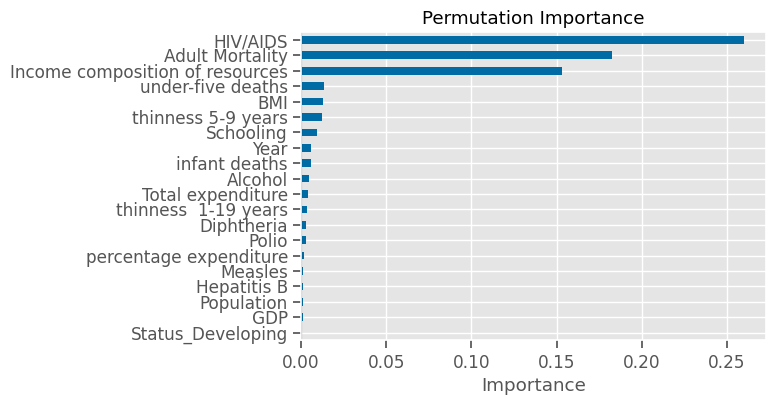

<Axes: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [13]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(rf_perm_importances, title='Permutation Importance')


> Permutation Importance Can Be Applied to ANY Model!

# üïπÔ∏èGlobal Model Explanations

##  Applying Shap

In [14]:
# Import and init shap
import shap
shap.initjs()


### Gather a small random sample to speed the process

In [15]:
# Take a sample of the training data (nsamples=500, use random_state=SEED)
X_shap = shap.sample(X_train_proc, nsamples = 500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()


Year  Adult Mortality  infant deaths  Alcohol  \
2301 2,011.0000         418.0000        26.0000   3.7800   
526  2,001.0000          54.0000        17.0000   1.5200   
2911 2,010.0000         363.0000        30.0000   2.4700   
2601 2,015.0000         152.0000         2.0000   4.5801   
434  2,013.0000         412.0000        59.0000   3.1500   

      percentage expenditure  Hepatitis B     Measles     BMI  \
2301                 54.6659      89.0000  1,865.0000 22.2000   
526                  33.6532      81.4389  2,837.0000 16.8000   
2911                184.3649      83.0000 15,754.0000  2.7000   
2601                  0.0000      76.0000     43.0000 17.4000   
434                   0.0000       8.0000     48.0000 26.8000   

      under-five deaths   Polio  Total expenditure  Diphtheria  HIV/AIDS  \
2301            38.0000 88.0000            11.9800     89.0000    1.3000   
526             25.0000  4.0000             3.9500      4.0000   13.9000   
2911            45.0000  8.0000             4.4100     83.0000    6.8000   
2601             2.0000 75.0000             5.9320     76.0000    0.1000   
434             81.0000 79.0000             5.8100      8.0000    2.4000   

            GDP      Population  thinness  1-19 years  thinness 5-9 years  \
2301   445.5250  6,611,692.0000                8.1000              8.0000   
526    243.1586    383,223.0000                1.4000              1.4000   
2911 1,463.2136    138,533.0000                6.7000              6.5000   
2601 1,161.7694    124,977.0000                1.9000             11.1000   
434  7,619.0888 11,067,208.8431                5.8000              5.7000   

      Income composition of resources  Schooling  Status_Developing  
2301                           0.3920     8.9000             1.0000  
526                            0.3140     5.3000             1.0000  
2911                           0.5330    11.8000             1.0000  
2601                           0.6030    12.5000             1.0000  
434                            0.6283    11.9737             1.0000

## <center> SHAP Model Usage

![shap usage by model](../Data/SHAPcheatsheet.png)

### Create SHAP Explainer and SHAP Values for Random Forest Model

In [16]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap)

In [17]:
rf_shap_values.shape

(500, 20)

### Shap Values Contents

Shap values includes the values for each feature, base values, and original data FOR EACH ROW

So, 500 rows by 20 features

In [18]:
rf_shap_values[0]

.values =
array([ 1.01255253e-01, -6.39564667e+00, -2.90097893e-01, -6.65639251e-02,
       -5.65359654e-02,  2.07667989e-02, -4.71362639e-02, -1.01805031e-01,
       -4.04883961e-01,  6.93402607e-02, -6.95018475e-02,  6.52202809e-02,
       -8.30877989e+00, -7.97570237e-02, -3.63492634e-02, -1.22042304e-01,
       -1.34545944e-01, -3.01570421e+00, -8.68881555e-01,  6.67372715e-04])

.base_values =
array([69.19298179])

.data =
array([2.01100000e+03, 4.18000000e+02, 2.60000000e+01, 3.78000000e+00,
       5.46659175e+01, 8.90000000e+01, 1.86500000e+03, 2.22000000e+01,
       3.80000000e+01, 8.80000000e+01, 1.19800000e+01, 8.90000000e+01,
       1.30000000e+00, 4.45525000e+02, 6.61169200e+06, 8.10000000e+00,
       8.00000000e+00, 3.92000000e-01, 8.90000000e+00, 1.00000000e+00])

### Summary Bar Plot: Random Forest

The `show=False` flag will allow us to manipulate the figure using matplotlib.

Text(0.5, 1.0, 'Random Forest SHAP Summary')

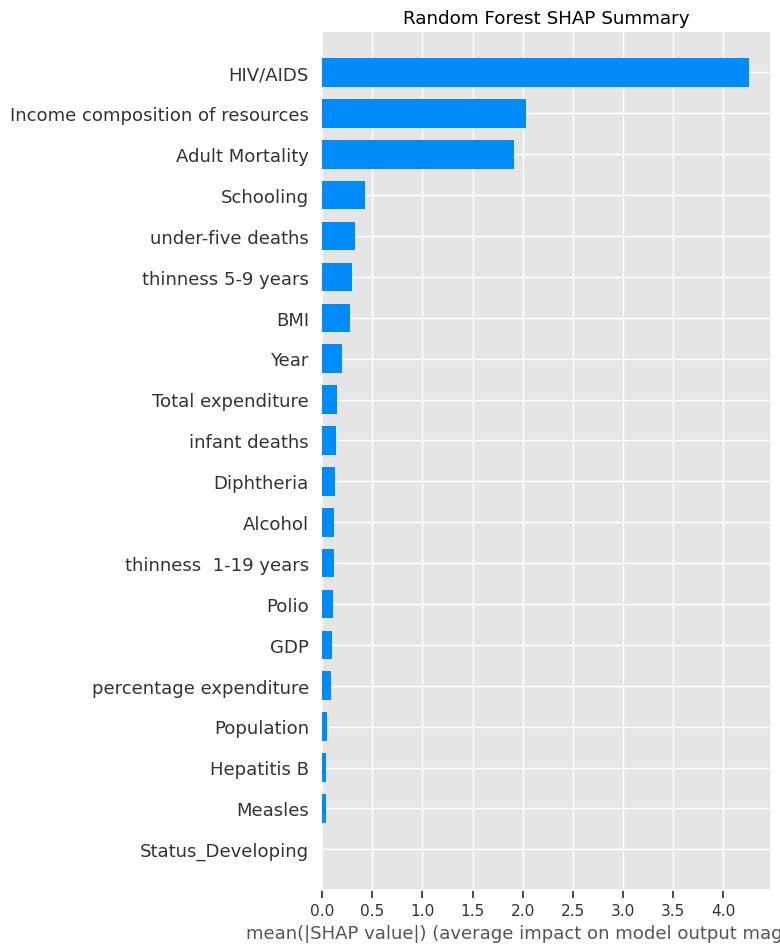

In [19]:
## create a summary plot (bar version)
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Random Forest SHAP Summary')

### SHAP Dot Plot for Random Forest Model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


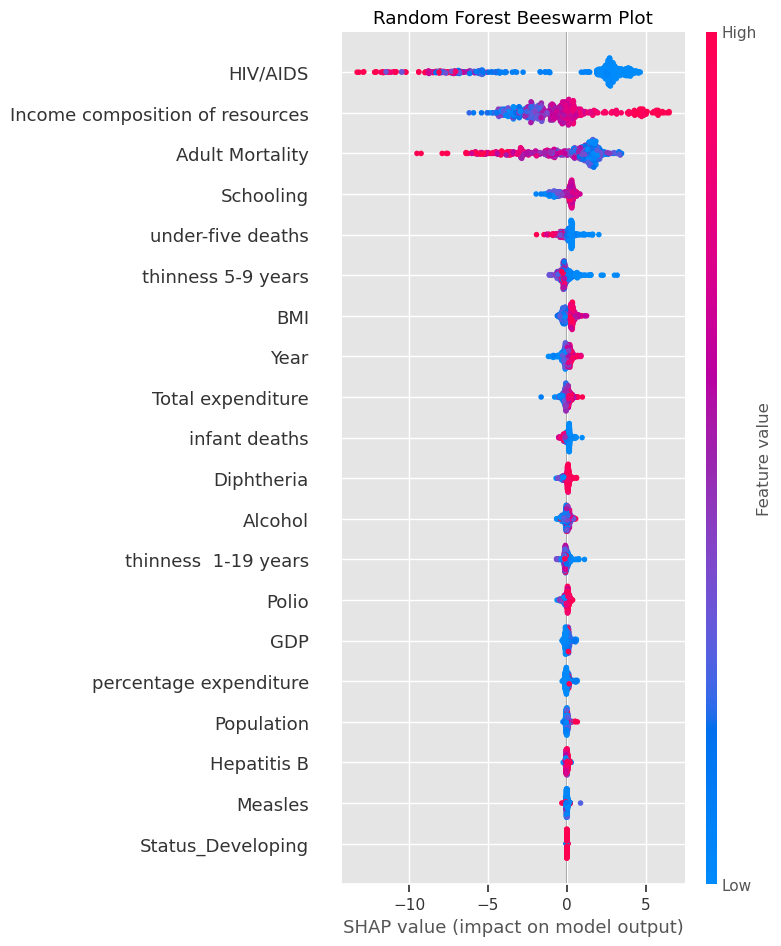

In [20]:
## create a summary plot for Random Forest (dot/default version)
shap.summary_plot(rf_shap_values, features=X_shap, show=False)

plt.title('Random Forest Beeswarm Plot')
plt.show();

## Local Explanations

In [21]:
print(X_shap.index[:5])

Int64Index([2301, 526, 2911, 2601, 434], dtype='int64')


### Reset Index

We need to be able to match a sample from X_shap to its Shap value, so we need to reindex.

In [22]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()


Year  Adult Mortality  infant deaths  Alcohol  percentage expenditure  \
0 2,011.0000         418.0000        26.0000   3.7800                 54.6659   
1 2,001.0000          54.0000        17.0000   1.5200                 33.6532   
2 2,010.0000         363.0000        30.0000   2.4700                184.3649   
3 2,015.0000         152.0000         2.0000   4.5801                  0.0000   
4 2,013.0000         412.0000        59.0000   3.1500                  0.0000   

   Hepatitis B     Measles     BMI  under-five deaths   Polio  \
0      89.0000  1,865.0000 22.2000            38.0000 88.0000   
1      81.4389  2,837.0000 16.8000            25.0000  4.0000   
2      83.0000 15,754.0000  2.7000            45.0000  8.0000   
3      76.0000     43.0000 17.4000             2.0000 75.0000   
4       8.0000     48.0000 26.8000            81.0000 79.0000   

   Total expenditure  Diphtheria  HIV/AIDS        GDP      Population  \
0            11.9800     89.0000    1.3000   445.5250  6,611,692.0000   
1             3.9500      4.0000   13.9000   243.1586    383,223.0000   
2             4.4100     83.0000    6.8000 1,463.2136    138,533.0000   
3             5.9320     76.0000    0.1000 1,161.7694    124,977.0000   
4             5.8100      8.0000    2.4000 7,619.0888 11,067,208.8431   

   thinness  1-19 years  thinness 5-9 years  Income composition of resources  \
0                8.1000              8.0000                           0.3920   
1                1.4000              1.4000                           0.3140   
2                6.7000              6.5000                           0.5330   
3                1.9000             11.1000                           0.6030   
4                5.8000              5.7000                           0.6283   

   Schooling  Status_Developing  
0     8.9000             1.0000  
1     5.3000             1.0000  
2    11.8000             1.0000  
3    12.5000             1.0000  
4    11.9737             1.0000

### Finding a Meaningful  Example to Explain

- Let's find the example with the longest life expectancy.

In [23]:
## What is the range of life expectancies?

y_shap_local.describe()

count   500.0000
mean     68.6210
std       9.5441
min      44.6000
25%      62.1000
50%      71.7000
75%      75.3000
max      89.0000
Name: Life expectancy, dtype: float64

In [24]:
## saving the index of the longest life expectancy
idx_long_life = y_shap_local.idxmax()
idx_long_life

29

In [25]:
## what was the actual life expectancy?
y_shap_local.iloc[idx_long_life]


89.0

In [26]:
# checking the feature values for selected example
X_shap_local.iloc[idx_long_life]


Year                                  2,009.0000
Adult Mortality                          67.0000
infant deaths                             0.0000
Alcohol                                   6.6800
percentage expenditure                  142.3749
Hepatitis B                              81.4389
Measles                                   2.0000
BMI                                      58.5000
under-five deaths                         0.0000
Polio                                    94.0000
Total expenditure                         9.4900
Diphtheria                               94.0000
HIV/AIDS                                  0.1000
GDP                                     817.7768
Population                        4,828,726.0000
thinness  1-19 years                      0.7000
thinness 5-9 years                        0.7000
Income composition of resources           0.9360
Schooling                                17.4000
Status_Developing                         0.0000
Name: 29, dtype: flo

## Shap Force Plots

### Force Plot - RandomForest explanation

In [27]:
## plotting example force plot for longest life expectancy (from rf)

shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_long_life].values,
               features = X_shap_local.iloc[idx_long_life])

# LIME: Random Forest Local Explanation

In [28]:
from lime.lime_tabular import LimeTabularExplainer



## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [29]:
## Use the lime explainer to explain the selected example used above 
NUMBER_OF_FEATURES=20

exp = lime_explainer.explain_instance(X_shap_local.loc[idx_long_life],
                                      rf_reg.predict, num_features=NUMBER_OF_FEATURES)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


## Show Lime Explanation as PyPlot Figure

This view gets cramped and can be hard to see and read.  We can also show it as a pyplot figure that's easier to manipulate and read...and save!

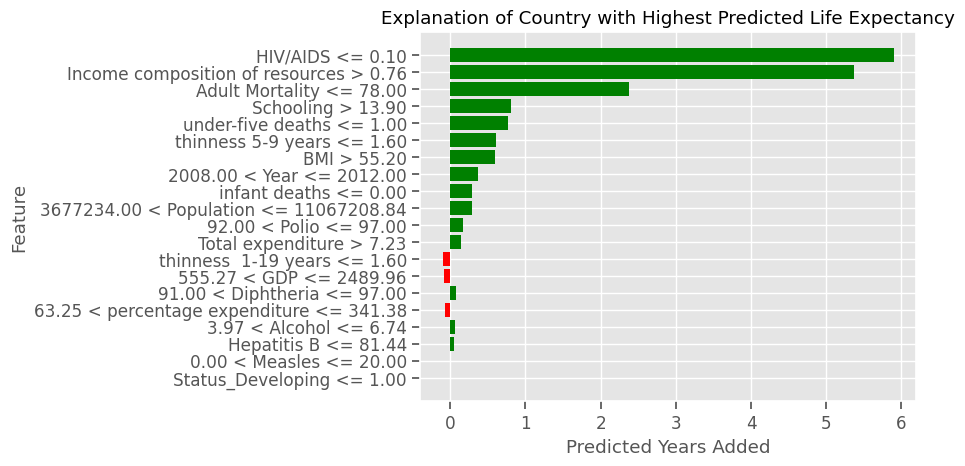

In [32]:
## Show as PyPlot figure

exp.as_pyplot_figure()
plt.title('Explanation of Country with Highest Predicted Life Expectancy')
plt.xlabel('Predicted Years Added')
plt.ylabel('Feature')
plt.savefig('long_life_lime_explanation.png')

___
# APPENDIX

### Global Force Plots

In [34]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values.values,X_shap_local,)